# KneeMRI Dataset

Using device: cuda
Starting Fold 1/7
Epoch [1/20]
Train Loss: 0.5689, Train Accu: 75.40% Train Loss: 0.6121, Train Accu: 73.13% val Loss: 0.6312, val Accu: 70.89% Prec: 0.7440, Recall: 0.7089, F1: 0.7047 AUC: 0.9016, Kappa: 0.5362 Sens: 0.4194, Spec: 0.9612 Dice Coeff: 0.5306 RMSE: 0.6167, MAE: 0.3208, MSE: 0.3803 PPV: 0.7222
Epoch [2/20]
Train Loss: 0.6211, Train Accu: 75.22% Train Loss: 0.7358, Train Accu: 70.98% val Loss: 0.6550, val Accu: 75.59% Prec: 0.7901, Recall: 0.7559, F1: 0.7250 AUC: 0.9457, Kappa: 0.5932 Sens: 0.2661, Spec: 1.0000 Dice Coeff: 0.4204 RMSE: 0.5973, MAE: 0.2817, MSE: 0.3568 PPV: 1.0000
Epoch [3/20]
Train Loss: 0.2836, Train Accu: 88.46% Train Loss: 0.2492, Train Accu: 89.35% val Loss: 0.3344, val Accu: 86.23% Prec: 0.8708, Recall: 0.8623, F1: 0.8631 AUC: 0.9659, Kappa: 0.7810 Sens: 0.7742, Spec: 0.9942 Dice Coeff: 0.8610 RMSE: 0.4073, MAE: 0.1471, MSE: 0.1659 PPV: 0.9697
Epoch [4/20]
Train Loss: 0.2682, Train Accu: 88.85% Train Loss: 0.2366, Train Accu: 89.73%

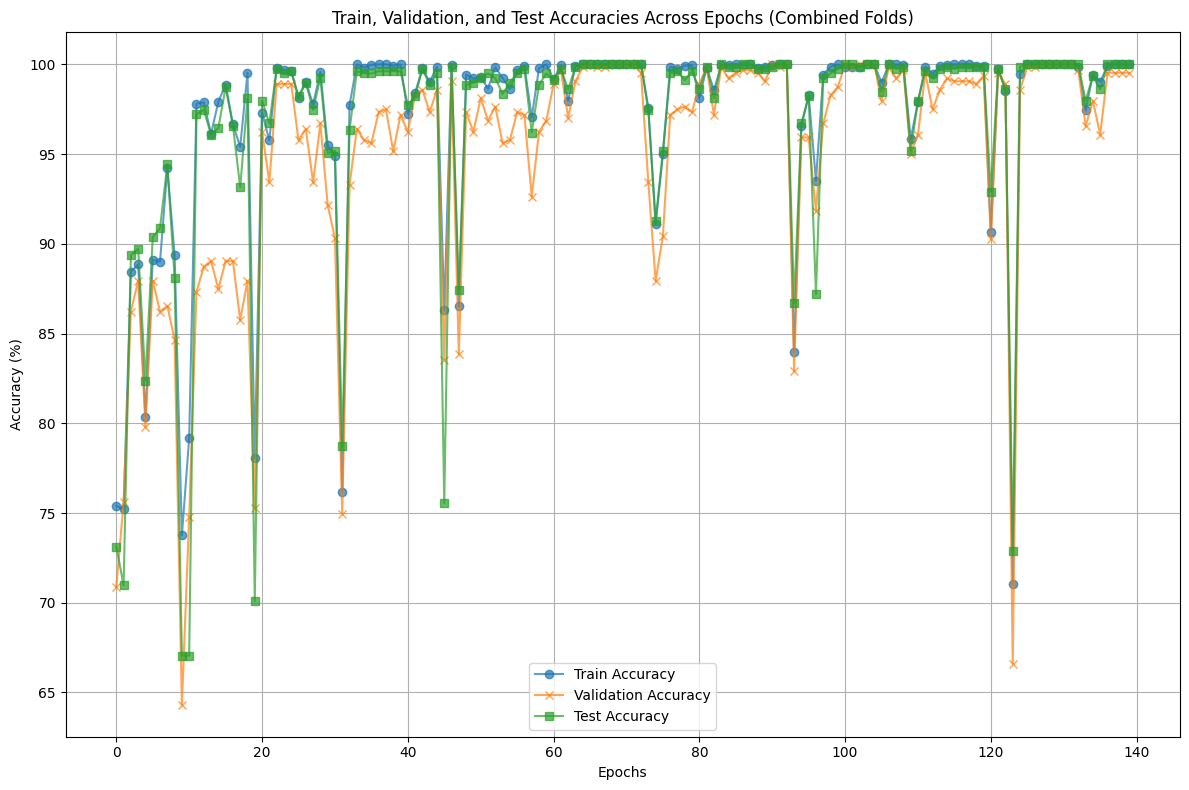

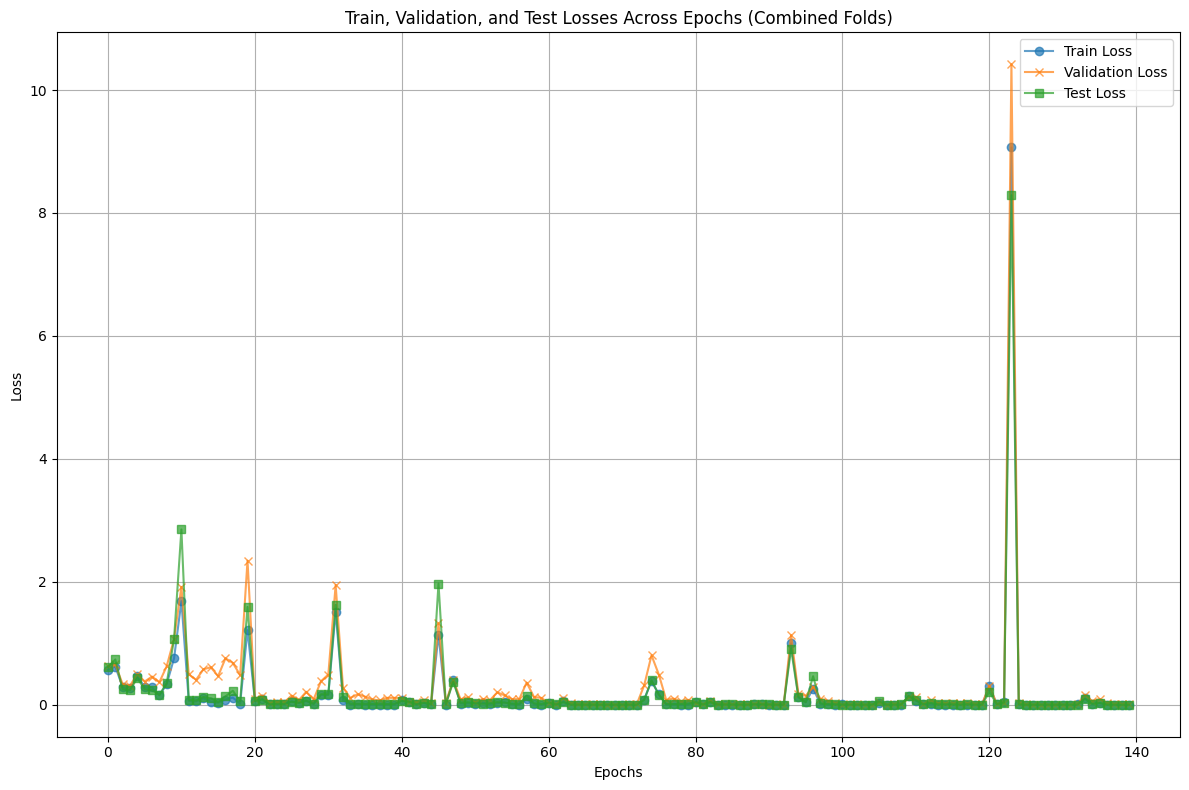

In [4]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, Subset , random_split
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import cohen_kappa_score, roc_curve, auc
import numpy as np

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the custom dataset class
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label in sorted(os.listdir(root_dir)):
            label_dir = os.path.join(root_dir, label)
            if os.path.isdir(label_dir):
                for img_name in os.listdir(label_dir):
                    if img_name.endswith('.jpg') or img_name.endswith('.png'):
                        img_path = os.path.join(label_dir, img_name)
                        self.image_paths.append(img_path)
                        self.labels.append(int(label))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')  # Ensure grayscale image loading
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalization for grayscale
])

# Load dataset
data_dir = 'new dataf'
full_dataset = CustomDataset(root_dir=data_dir, transform=transform)
train_size = int(0.85 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)
# Define the CNN model (already provided)
class DepthwiseSeparableConv(nn.Module):
    """Depthwise Separable Convolution Block"""

    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, 
                                   stride=stride, padding=padding, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class XceptionNet(nn.Module):
    """Xception-like Network"""

    def __init__(self, num_classes=3):
        super(XceptionNet, self).__init__()
        self.entry_flow = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(64, 128),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            DepthwiseSeparableConv(128, 256),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        self.middle_flow = nn.Sequential(
            *[DepthwiseSeparableConv(256, 256) for _ in range(8)]
        )
        self.exit_flow = nn.Sequential(
            DepthwiseSeparableConv(256, 512),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            DepthwiseSeparableConv(512, 1024),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.entry_flow(x)
        x = self.middle_flow(x)
        x = self.exit_flow(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
    
model = XceptionNet(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score

def evaluate_metrics(loader, model, criterion, device):
    model.eval()
    val_loss = 0.0
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            probs = F.softmax(outputs, dim=1).cpu().numpy()  # Probabilities for AUC
            preds = torch.argmax(outputs, dim=1).cpu().numpy()    # Predicted classes
            labels = labels.cpu().numpy()

            all_labels.extend(labels)
            all_preds.extend(preds)
            all_probs.extend(probs)

    # Convert to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Calculate metrics
     # Calculate metrics
    binary_labels = (all_labels == 2).astype(int)
    binary_preds = (all_preds == 2).astype(int)
    cm = confusion_matrix(binary_labels, binary_preds)
    
    
    # Handle multi-class confusion matrix 
    accuracy = accuracy_score(all_labels, all_preds)*100
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    # If binary classification calculate below metrics or use suitable multi-class metrics
    tn, fp, fn, tp = cm.ravel()
    auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')  # Use the probabilities for the positive class
    kappa = cohen_kappa_score(all_labels, all_preds)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    dice = (2 * tp) / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0

    rmse = np.sqrt(mean_squared_error(all_labels, all_preds))
    mae = mean_absolute_error(all_labels, all_preds)
    mse = mean_squared_error(all_labels, all_preds)

    metrics = {
        'Loss': val_loss / len(loader),
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': auc,
        'Kappa': kappa,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Dice Coefficient': dice,
        'RMSE': rmse,
        'MAE': mae,
        'MSE': mse,
        'PPV': ppv
    }

    return metrics

last_epoch_train_losses = []
last_epoch_train_accuracies = []
last_epoch_val_metrics = {
    'Loss': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'AUC': [],
    'Kappa': [],
    'Sensitivity': [],
    'Specificity': [],
    'Dice Coefficient': [],
    'RMSE': [],
    'MAE': [],
    'MSE': [],
    'PPV': []
}

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

# K-Fold Cross-Validation
k_folds = 7
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f"Starting Fold {fold + 1}/{k_folds}")
    
    # Subset datasets
    train_subset = Subset(full_dataset, train_idx)
    val_subset = Subset(full_dataset, val_idx)
    trainsub_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
    num_epochs = 20
    
    for epoch in range(20):  # Use smaller epochs for debugging; increase for full training
        model.train()
        running_loss = 0.0
        for images, labels in trainsub_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        
        train_metrics = evaluate_metrics(trainsub_loader, model, criterion, device)
        val_metrics = evaluate_metrics(val_loader, model, criterion, device)
        test_metrics = evaluate_metrics(test_loader, model, criterion, device)

        train_losses.append(train_metrics['Loss'])
        train_accuracies.append(train_metrics['Accuracy'])
        val_losses.append(val_metrics['Loss'])
        val_accuracies.append(val_metrics['Accuracy'])
        test_losses.append(test_metrics['Loss'])
        test_accuracies.append(test_metrics['Accuracy'])

        if epoch == num_epochs - 1:
            last_epoch_train_losses.append(running_loss / len(train_loader))
            last_epoch_train_accuracies.append(train_metrics['Accuracy'])
            for key in last_epoch_val_metrics:
                last_epoch_val_metrics[key].append(val_metrics[key])

        # Print metrics
        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        print(f"Train Loss: {train_metrics['Loss']:.4f}, Train Accu: {train_metrics['Accuracy']:.2f}%",
            f"Train Loss: {test_metrics['Loss']:.4f}, Train Accu: {test_metrics['Accuracy']:.2f}%",
            f"val Loss: {val_metrics['Loss']:.4f}, val Accu: {val_metrics['Accuracy']:.2f}%",
            f"Prec: {val_metrics['Precision']:.4f}, Recall: {val_metrics['Recall']:.4f}, "
            f"F1: {val_metrics['F1 Score']:.4f}",
            f"AUC: {val_metrics['AUC']:.4f}, Kappa: {val_metrics['Kappa']:.4f}",
            f"Sens: {val_metrics['Sensitivity']:.4f}, Spec: {val_metrics['Specificity']:.4f}",
            f"Dice Coeff: {val_metrics['Dice Coefficient']:.4f}",
            f"RMSE: {val_metrics['RMSE']:.4f}, MAE: {val_metrics['MAE']:.4f}, MSE: {val_metrics['MSE']:.4f}",
            f"PPV: {val_metrics['PPV']:.4f}")

avg_train_loss = np.mean(last_epoch_train_losses)
avg_train_accuracy = np.mean(last_epoch_train_accuracies)
avg_val_metrics = {key: np.mean(values) for key, values in last_epoch_val_metrics.items()}

# Print average metrics
print(f"Average Train Loss: {avg_train_loss:.4f}")
print(f"Average Train Accuracy: {avg_train_accuracy:.2f}%")
print("Average Validation Metrics:")
for key, value in avg_val_metrics.items():
    print(f"{key}: {value:.4f}")

import matplotlib.pyplot as plt

# After your training loop and evaluation, you can plot all metrics

# Plot Train, Validation, and Test Accuracy
plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(train_accuracies)), train_accuracies, label='Train Accuracy', linestyle='-', marker='o', alpha=0.7)
plt.plot(np.arange(len(val_accuracies)), val_accuracies, label='Validation Accuracy', linestyle='-', marker='x', alpha=0.7)
plt.plot(np.arange(len(test_accuracies)), test_accuracies, label='Test Accuracy', linestyle='-', marker='s', alpha=0.7)
plt.title('Train, Validation, and Test Accuracies Across Epochs (Combined Folds)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Train, Validation, and Test Losses
plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train Loss', linestyle='-', marker='o', alpha=0.7)
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation Loss', linestyle='-', marker='x', alpha=0.7)
plt.plot(np.arange(len(test_losses)), test_losses, label='Test Loss', linestyle='-', marker='s', alpha=0.7)
plt.title('Train, Validation, and Test Losses Across Epochs (Combined Folds)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
from torch.utils.data import Dataset, DataLoader, random_split

test_metrics = evaluate_metrics(test_loader, model, criterion, device)

# Print metrics
print(f"test Loss: {test_metrics['Loss']:.4f}, test Accu: {test_metrics['Accuracy']:.2f}%")

test Loss: 0.0001, test Accu: 100.00%
